# Visualising Place Entities on Maps

<a target="_blank" href="https://colab.research.google.com/github/impresso/impresso-datalab-notebooks/blob/main/4-impresso-py/maps_explore.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## Install dependencies

We need the following packages:

 * [impresso-py](https://impresso-project.ch/)
 * [ipyleaflet](https://ipyleaflet.readthedocs.io/en/latest/index.html)

In [1]:
%pip install -q impresso ipyleaflet

Note: you may need to restart the kernel to use updated packages.


## Connect to the Impresso API

In [1]:
from impresso import connect, OR, DateRange

impresso = connect()

🎉 You are now connected to the Impresso API!  🎉


## Search and collect entities

Find top 100 location entities mentioned in articles that talk about nuclear power plants in the first three decades following the second world war in English, French and German.

,count,uid,item.uid
val,,,
aida-0001-54-Switzerland,1117,aida-0001-54-Switzerland,aida-0001-54-Switzerland
aida-0001-54-Suisse$2c$_Moselle,799,aida-0001-54-Suisse$2c$_Moselle,aida-0001-54-Suisse$2c$_Moselle
aida-0001-54-Lausanne,514,aida-0001-54-Lausanne,aida-0001-54-Lausanne

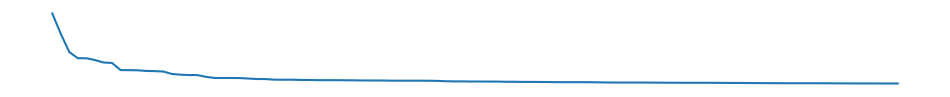

In [2]:
locations = impresso.search.facet(
    "location",
    q=OR("centrale nucléaire", "nuclear power plant", "Kernkraftwerk"),
    date_range=DateRange("1945-05-01", "1975-05-01"),
    limit=100,
    order_by="-count"
)
locations

Get entities details, including wikidata details

In [3]:
entities_ids = locations.df.index.tolist()
entities = impresso.entities.find(entity_id=OR(*entities_ids), load_wikidata=True, limit=len(entities_ids))
entities

,name,type,countItems,countMentions,wikidataId,wikidata.coordinates.latitude,wikidata.coordinates.longitude,wikidata.coordinates.altitude,wikidata.coordinates.precision,wikidata.coordinates.globe,wikidata.country.id,wikidata.country.type,wikidata.country.labels.de,wikidata.country.labels.en,wikidata.country.labels.fr,wikidata.country.labels.it,wikidata.country.descriptions.fr,wikidata.country.descriptions.it,wikidata.country.descriptions.de,wikidata.country.descriptions.en,wikidata.country.images,wikidata.country.coordinates.latitude,wikidata.country.coordinates.longitude,wikidata.country.coordinates.altitude,wikidata.country.coordinates.precision,wikidata.country.coordinates.globe,wikidata.country.country.entity-type,wikidata.country.country.numeric-id,wikidata.country.country.id,wikidata.id,wikidata.type,wikidata.labels.en,wikidata.labels.it,wikidata.labels.de,wikidata.labels.fr,wikidata.descriptions.en,wikidata.descriptions.it,wikidata.descriptions.de,wikidata.descriptions.fr,wikidata.images,wikidata.country.entity-type,wikidata.country.numeric-id,wikidata.country.country.type,wikidata.country.country.labels.de,wikidata.country.country.labels.en,wikidata.country.country.labels.fr,wikidata.country.country.labels.it,wikidata.country.country.descriptions.fr,wikidata.country.country.descriptions.it,wikidata.country.country.descriptions.de,wikidata.country.country.descriptions.en,wikidata.country.country.images,wikidata.country.country.coordinates.latitude,wikidata.country.country.coordinates.longitude,wikidata.country.country.coordinates.altitude,wikidata.country.country.coordinates.precision,wikidata.country.country.coordinates.globe,wikidata.country.country.country.entity-type,wikidata.country.country.country.numeric-id,wikidata.country.country.country.id,wikidata.birthDate,wikidata.deathDate,wikidata.birthPlace.id,wikidata.birthPlace.type,wikidata.birthPlace.labels.fr,wikidata.birthPlace.labels.en,wikidata.birthPlace.labels.it,wikidata.birthPlace.labels.de,wikidata.birthPlace.descriptions.fr,wikidata.birthPlace.descriptions.it,wikidata.birthPlace.descriptions.en,wikidata.birthPlace.descriptions.de,wikidata.birthPlace.images,wikidata.birthPlace.coordinates.latitude,wikidata.birthPlace.coordinates.longitude,wikidata.birthPlace.coordinates.altitude,wikidata.birthPlace.coordinates.precision,wikidata.birthPlace.coordinates.globe,wikidata.birthPlace.country.entity-type,wikidata.birthPlace.country.numeric-id,wikidata.birthPlace.country.id,wikidata.deathPlace.id,wikidata.deathPlace.type,wikidata.deathPlace.labels.fr,wikidata.deathPlace.labels.it,wikidata.deathPlace.labels.de,wikidata.deathPlace.labels.en,wikidata.deathPlace.descriptions.it,wikidata.deathPlace.descriptions.en,wikidata.deathPlace.descriptions.fr,wikidata.deathPlace.descriptions.de,wikidata.deathPlace.images,wikidata.deathPlace.coordinates.latitude,wikidata.deathPlace.coordinates.longitude,wikidata.deathPlace.coordinates.altitude,wikidata.deathPlace.coordinates.precision,wikidata.deathPlace.coordinates.globe,wikidata.deathPlace.country.entity-type,wikidata.deathPlace.country.numeric-id,wikidata.deathPlace.country.id
uid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
aida-0001-54-Lausanne,Lausanne,location,2918317,4642691,Q807,46.533333,6.633333,NaN,0.016667,http://www.wikidata.org/entity/Q2,Q39,location,Schweiz,Switzerland,Suisse,Svizzera,pays d'Europe centrale,stato dell'Europa centrale,Staat in Mitteleuropa,country in Central Europe,[{'value': 'Flag of Switzerland (Pantone).svg'...,46.798562,8.231973,NaN,0.000001,http://www.wikidata.org/entity/Q2,item,39.0,Q39,Q807,location,Lausanne,Losanna,Lausanne,Lausanne,"capital city of the canton of Vaud, Switzerland",città della Svizzera,Schweizer Stadt und Hauptstadt des Kantons Waadt,"ville de Suisse, chef-lieu du canton de Vaud","[{'value': 'Lausanne img 0585.jpg', 'rank': 'n...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

Filter out entities that have no coordinates and add a country tag.

In [22]:
import pandas as pd
# disable "copy-on-write" warning
pd.options.mode.copy_on_write = True

df = entities.df
entities_with_coordinates = df[df['wikidata.coordinates.latitude'].notna() & df['wikidata.coordinates.longitude'].notna()]

# entity-type == "item" indicates it's a country
entities_with_coordinates['is_country'] = entities_with_coordinates['wikidata.descriptions.fr'].str.contains('pays')
entities_with_coordinates

,name,type,countItems,countMentions,wikidataId,wikidata.coordinates.latitude,wikidata.coordinates.longitude,wikidata.coordinates.altitude,wikidata.coordinates.precision,wikidata.coordinates.globe,...,wikidata.deathPlace.images,wikidata.deathPlace.coordinates.latitude,wikidata.deathPlace.coordinates.longitude,wikidata.deathPlace.coordinates.altitude,wikidata.deathPlace.coordinates.precision,wikidata.deathPlace.coordinates.globe,wikidata.deathPlace.country.entity-type,wikidata.deathPlace.country.numeric-id,wikidata.deathPlace.country.id,is_country
uid,,,,,,,,,,,,,,,,,,,,,
aida-0001-54-Lausanne,Lausanne,location,2918317,4642691,Q807,46.533333,6.633333,NaN,0.016667,http://www.wikidata.org/entity/Q2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
aida-0001-54-Suisse$2c$_Moselle,"Suisse, Moselle",location,2561532,4268837,Q22036,48.965833,6.579444,NaN,0.000278,http://www.wikidata.org/entity/Q2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
aida-0001-54-Switzerland,Switzerland,location,2390778,4727170,Q39,46.798562,8.231973,NaN,0.000001,http://www.wikidata.org/entity/Q2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
aida-0001-54-Fribourg,Fribourg,location,2286590,4264647,Q36378,46.800000,7.150000,NaN,0.016667,http://www.wikidata.org/entity/Q2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
aida-0001-54-Paris,Paris,location,2132568,3551470,Q90,48.856944,2.351389,NaN,0.000278,http://www.wikidata.org/entity/Q2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
aida-0001-54-Mannheim,Mannheim,location,31397,40884,Q2119,49.487778,8.466111,NaN,0.000278,http://www.wikidata.org/entity/Q2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
aida-0001-54-Baden-Württemberg,Baden-Württemberg,location,10124,13277,Q985,48.537778,9.041111,NaN,0.016667,http://www.wikidata.org/entity/Q2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
aida-0001-54-Haut-Rhin,Haut-Rhin,location,6388,7590,Q12722,47.964167,7.319722,NaN,0.000010,http://www.wikidata.org/entity/Q2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


Add counts of mentions to the entities dataframe.

In [23]:
entities_with_coordinates['mentions_count'] = entities_with_coordinates.index.map(locations.df['count'])

Plot entities on the map.

### Utility methods

Functions used to calculate extra details needed to plot data on a map.

Find geo bounds of a group of items.

In [24]:
def find_bounds(coordinates):
  """
  Finds the top/left, bottom/right bounds of an area that fits all coordinates.

  Args:
    coordinates: A list of coordinate tuples (latitude, longitude).

  Returns:
    A tuple containing the top/left and bottom/right bounds:
      ((top_lat, left_lon), (bottom_lat, right_lon))
  """
  if not coordinates:
    return None

  min_lat = coordinates[0][0]
  max_lat = coordinates[0][0]
  min_lon = coordinates[0][1]
  max_lon = coordinates[0][1]

  for lat, lon in coordinates:
    min_lat = min(min_lat, lat)
    max_lat = max(max_lat, lat)
    min_lon = min(min_lon, lon)
    max_lon = max(max_lon, lon)

  return ((max_lat, min_lon), (min_lat, max_lon))


Create an HTML used for rendering the hover pop-up.

In [25]:
from ipywidgets import HTML
from ipyleaflet import Popup

def build_hover_popup(title: str, subtitle: str, mentions: int) -> Popup:
  message = HTML()
  message.value = f"""
    <div style="display: flex; flex-direction: column; color: black; line-height: normal; max-width: 200px;">
      <b>{title}</b>
      <p>{subtitle}</p>
      <b>Mentions: {mentions}</b>
    </div>
  """

  # Popup with a given location on the map:
  popup = Popup(
      # location=center,
      child=message,
      close_button=False,
      auto_close=True,
      close_on_escape_key=False
  )
  return popup

### Map with adaptive pins

Display entities on a map with pin size based on the number of mentions (more mentions = bigger pin). The pins are colored based on the type of the entity (country or location).

In [26]:
from ipyleaflet import Map, Marker, AwesomeIcon, CircleMarker

map = Map(zoom=0)

country_icon = AwesomeIcon(
  name='fa-globe',
  marker_color='red',
  spin=False,
)

place_icon = AwesomeIcon(
  name='fa-building-o',
  marker_color='green',
  spin=False,
)

max_mentions_count = entities_with_coordinates['mentions_count'].max()

coordinates = []
markers = []
# Build markers
for index, row in entities_with_coordinates.iterrows():
    lat = row['wikidata.coordinates.latitude']
    lon = row['wikidata.coordinates.longitude']
    label = row['wikidata.labels.en']
    description = row['wikidata.descriptions.en']
    is_country = row['is_country']

    radius = (row['mentions_count'] / max_mentions_count) * 20

    # marker = Marker(
    #   icon=country_icon if is_country else place_icon,
    #   location=(lat, lon),
    #   draggable=False,
    #   title=label
    # )

    marker = CircleMarker(
      location=(lat, lon),
      draggable=False,
      title=label,
      color="red" if is_country else "green",
      fill_color="red" if is_country else "green",
      radius=int(radius)
    )

    marker.popup = build_hover_popup(label, description, row['mentions_count'])

    coordinates.append((lat, lon))
    markers.append(marker)


# Fit the map to the bounds
map.fit_bounds(find_bounds(coordinates))

# add markers
for m in markers:
  map += m


display(map)

Map(center=[0.0, 0.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

### Heatmap

Display entities on a map with a heatmap overlay where the colour intensity is higher where the entities are more concentrated and more frequently mentioned.

In [44]:
from ipyleaflet import Map, Heatmap

map = Map(zoom=0)

locations = []
for index, row in entities_with_coordinates.iterrows():
    lat = row['wikidata.coordinates.latitude']
    lon = row['wikidata.coordinates.longitude']
    # add every coordinate 30 times to make the heatmap more visible
    locations.extend([(lat, lon) for i in range(30)])

heatmap = Heatmap(
    locations=locations,
    radius=20,
    blur=10,
)

map.add(heatmap)

map

Map(center=[0.0, 0.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…